# Demonstrating Artifacts in an Audio Classification Model

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
filename = 'data/audio/dog_bark.wav'

In [ ]:
import torch

model = torch.hub.load('harritaylor/torchvggish', 'vggish')
model.eval()



## Average Feature Maps for a 0-valued Input

In [4]:
save_acts = True

In [5]:
activations = {}
def save_activation(name):
    def hook(mod, inp, out):
        if save_acts:
            activations[name] = out.detach().numpy()
    return hook
    
for name, mod in model.named_modules():
    mod.register_forward_hook(save_activation(name))



In [6]:
model.preprocess = False
outp = model.forward(torch.zeros([4,1, 96, 64]))
model.preprocess = True

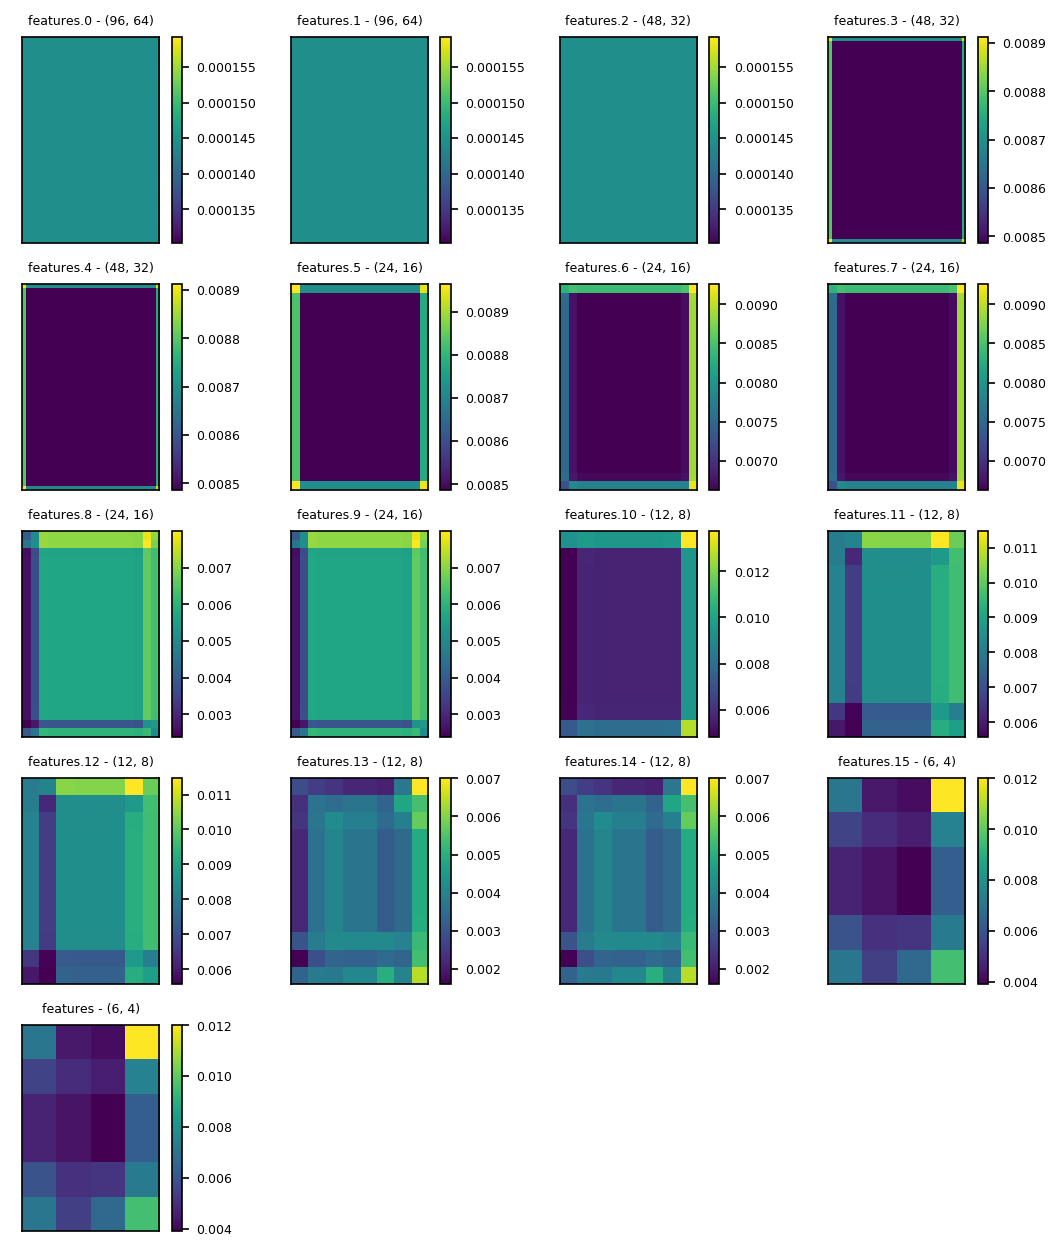

In [7]:
num_of_maps = len(activations)
fig = plt.figure(figsize=(7,15), dpi=150)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)
ind = 0
for key in activations:
    avg_feat_map = np.mean(activations[key], axis=(0, 1))
    if len(avg_feat_map.shape) == 2: # fc layer
        ax = fig.add_subplot(int(num_of_maps / 4) + 1, 4, ind + 1)
        ax.set_title("{} - {}".format(key, avg_feat_map.shape), fontsize=6)
        plt.imshow(avg_feat_map)
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=6) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ind += 1




## Average Kernels

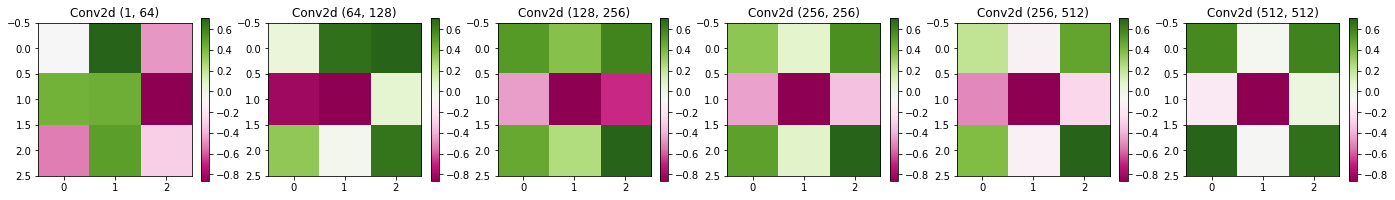

In [8]:
import matplotlib.pyplot as plt

# visualize weights here
sum_weights_conv2d_0 = model.features[0].weight.sum(axis=(0,1))
sum_weights_conv2d_3 = model.features[3].weight.sum(axis=(0,1))
sum_weights_conv2d_6 = model.features[6].weight.sum(axis=(0,1))
sum_weights_conv2d_8 = model.features[8].weight.sum(axis=(0,1))
sum_weights_conv2d_11 = model.features[11].weight.sum(axis=(0,1))
sum_weights_conv2d_13 = model.features[13].weight.sum(axis=(0,1))


fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(4*6, 3*1))
cmap=plt.get_cmap('PiYG')

img1 = axes[0].imshow(sum_weights_conv2d_0.cpu().detach().numpy(), cmap=cmap)
axes[0].set_title('Conv2d ({}, {})'.format(model.features[0].in_channels, model.features[0].out_channels))

img2 = axes[1].imshow(sum_weights_conv2d_3.cpu().detach().numpy(), cmap=cmap)
axes[1].set_title('Conv2d ({}, {})'.format(model.features[3].in_channels, model.features[3].out_channels))

img2 = axes[2].imshow(sum_weights_conv2d_6.cpu().detach().numpy(), cmap=cmap)
axes[2].set_title('Conv2d ({}, {})'.format(model.features[6].in_channels, model.features[6].out_channels))

img3 = axes[3].imshow(sum_weights_conv2d_8.cpu().detach().numpy(), cmap=cmap)
axes[3].set_title('Conv2d ({}, {})'.format(model.features[8].in_channels, model.features[8].out_channels))

img4 = axes[4].imshow(sum_weights_conv2d_11.cpu().detach().numpy(), cmap=cmap)
axes[4].set_title('Conv2d ({}, {})'.format(model.features[11].in_channels, model.features[11].out_channels))

img5 = axes[5].imshow(sum_weights_conv2d_13.cpu().detach().numpy(), cmap=cmap)
axes[5].set_title('Conv2d ({}, {})'.format(model.features[13].in_channels, model.features[13].out_channels))

fig.colorbar(img1, ax=axes[0])
fig.colorbar(img1, ax=axes[1])
fig.colorbar(img1, ax=axes[2])
fig.colorbar(img1, ax=axes[3])
fig.colorbar(img1, ax=axes[4])
fig.colorbar(img1, ax=axes[5])

## Testing Shift Invariance Under Different Padding Methods

We placed dog barking segment within a uniform input and shifted it along X and Y axes by one pixel at a time in one of those directions. Model prediction results for each shift are accumulated in a matrix. We compute and depic this matrix under zero padding, circular padding, and a mixed padding: circular padding applied to the X axis (Frames) and replication padding applied to the Y axis (Log-Mel Frequency Bands).

In [9]:
inp_modif = torch.zeros([2, 1, 96, 64])
inp_modif[0,:,:,50] = torch.ones(1, 96)


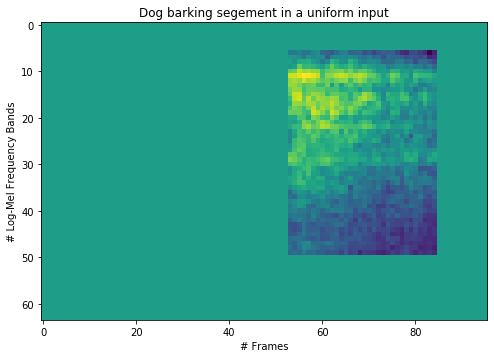

In [10]:
# visualizing barking dog segment in a uniform input

bark = model._preprocess('data/audio/dog_bark.wav', None)

bark_modif = bark.clone()
bark_modif = torch.zeros(1, 1, 96, 64)

bark_block = bark[0,:,63:95,6:50]

bark_modif[0,:,53:85,6:50] = bark_block

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4*2, 4*2))

axes.imshow(bark_modif.squeeze().transpose(1,0).cpu().detach().numpy())
axes.set_title('Dog barking segement in a uniform input')
axes.set_xlabel('# Frames')
axes.set_ylabel('# Log-Mel Frequency Bands')

plt.show()


In [ ]:
from vggish.model import VGGishClassify, get_vggish, vggish_category_metadata

In [11]:
#Vggish with classifier head
model_with_classifier = get_vggish(with_classifier=True)


In [12]:
#madel_with_classifier.preprocess = True
bark = model._preprocess('data/audio/dog_bark.wav', None)
bark_block = bark[0,:,63:95,6:50] #  32 x 44

def predict_4_translation_inv():
    # pred dog barking

    label_matrix = torch.zeros(64, 20)
    for i in range(64):
        for j in range(20):
            bark_modif = torch.zeros(1, 1, 96, 64)
            bark_modif[0,:,i:i+32,j:j+44] = bark_block
            output = model_with_classifier(bark_modif)
            out_max_idx = torch.max(torch.softmax(output, axis=1), axis=1)
            label_matrix[i][j] = out_max_idx.indices[0]
    return label_matrix

In [13]:
label_matrix = predict_4_translation_inv()

In [14]:
# reading label map
labels = vggish_category_metadata()

### Result under 0 Padding

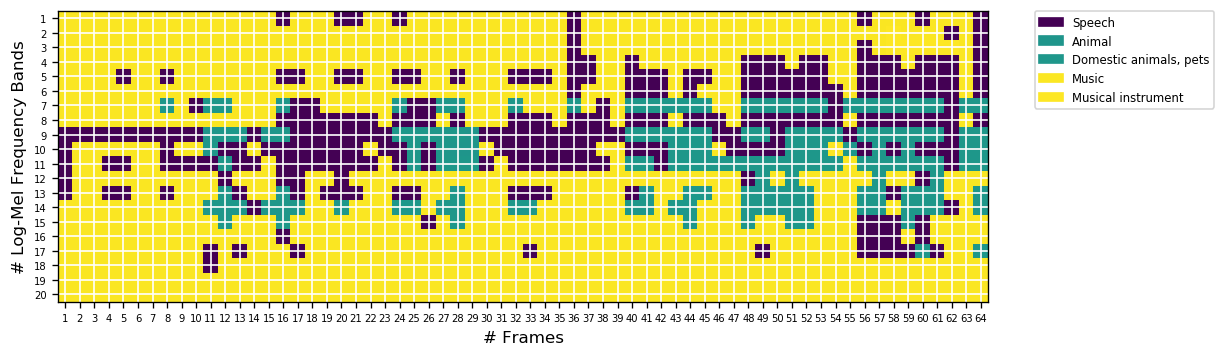

In [15]:
# visualize a matrix of predicted labels after shifting dog barking segment for all-side zero padding

import matplotlib.patches as mpatches

NUM_COLORS = 6

def plot_trans_inv_preds():
    fig = plt.figure(figsize=(10,50), dpi=120)
    ax = plt.gca()

    #cm = plt.get_cmap('ocean')

    ax.grid(color='w', linestyle='-', linewidth=1)
    ax.set_yticks(np.arange(0, 20, 1));
    ax.set_xticks(np.arange(0, 64, 1))
    ax.set_yticklabels(np.arange(1, 21, 1))
    ax.set_xticklabels(np.arange(1, 65, 1))
    ax.tick_params(labelsize=6)


    ax.set_xlabel('# Frames')
    ax.set_ylabel('# Log-Mel Frequency Bands')

    data = label_matrix.transpose(1,0).detach().numpy()
    im = plt.imshow(data)

    values = np.unique(data.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]

    patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=labels[int(values[i])]['name']) ) for i in range(len(values))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 7} )

plot_trans_inv_preds()

Interestingly, the classifier is able to predict animal, pets’ bark (green labels) when the frame is mostly placed central in the input. This, however, is not consistent across all positions in the center. We would expect to see better translation invariance along the Frames axis.

### Result under Circular Padding

In [16]:
def pad(x, pad=(1,1), type='circular'):
    """

    :param x: shape [H, W]
    :param pad: int >= 0
    :return:
    """
    if type == 'circular':
        # circular
        x = torch.cat([x, x[:,:,0:pad[0],:]], dim=2)

        # circular
        x = torch.cat([x, x[:,:, :, 0:pad[0]]], dim=3)
        
        # circular
        x = torch.cat([x[:, :, -2 * pad[0]:-pad[0], :], x], dim=2)

        # circular
        x = torch.cat([x[:, :, :, -2 * pad[0]:-pad[0]], x], dim=3)       
        return x
    if type == 'replication':
        # replication
        x = torch.cat([x, torch.flip(x[:,:,-pad[0]: ,:], [2])], dim=2)

        # replication
        x = torch.cat([x, torch.flip(x[:, :, :, -pad[1]:], [3])], dim=3)

        # replication
        x = torch.cat([torch.flip(x[:, :, 0:pad[0], :], [2]), x], dim=2)

        # replication
        x = torch.cat([torch.flip(x[:, :, :, 0:pad[1]], [3]), x], dim=3)
        return  x

    # reflection
    #print(x[:,:, :, 0:pad[0]], torch.flip(x[:,:, :, 0:pad[0]], [3]), x[:, :, :, -pad[1]:], torch.flip(x[:, :, :, -pad[1]:], [1]))
    #x = torch.cat([x, torch.flip(x[:,:, :, 0:pad[0]], [3])], dim=3)
 

    # reflection
    #x = torch.cat([torch.flip(x[:, :, :, -2 * pad[0]:-pad[0]], [3]), x], dim=3)

    return x

In [17]:
#Vggish with classifier head
model_with_classifier = get_vggish(with_classifier=True)


In [18]:
hooks = []

def apply_padding(mod):
  if isinstance(mod, torch.nn.Conv2d):
    def pre_hook(p_mod, inputs):
        inputs_modif = pad(inputs[0], type=type)
        mod.padding = tuple(0 for elem in mod.padding)
        return (inputs_modif, )
    hook = mod.register_forward_pre_hook(pre_hook)
    hooks.append(hook)



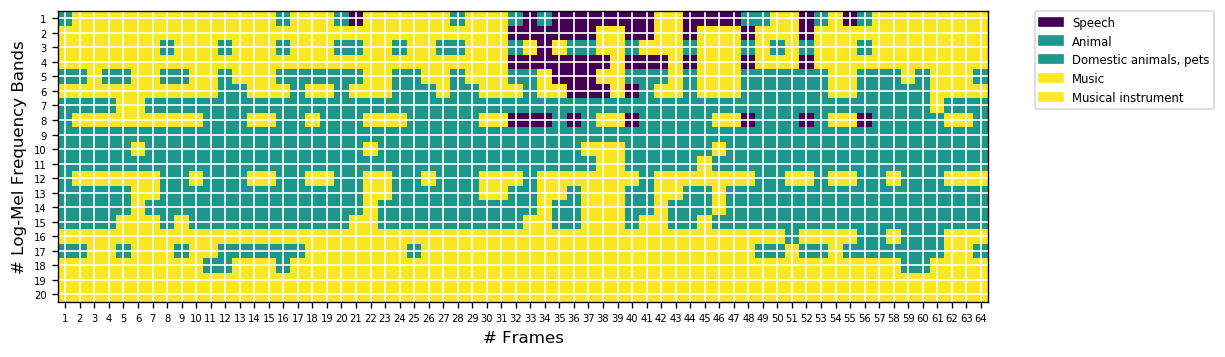

In [19]:
# circular padding
type = 'circular'
model_with_classifier.apply(apply_padding)
label_matrix = predict_4_translation_inv()
plot_trans_inv_preds()
for hook in hooks:
    hook.remove()
hooks = []

this case we are able to predict domestic animals’, pets’ barking in more locations than for the zero padding. This suggests that circular padding improves translation invariance. , However, it should be noted that circular padding might alter the content of the input. For that reason we decided to use different padding techniques for the vertical axis.

### Result under Mixed Circular and Replication Padding

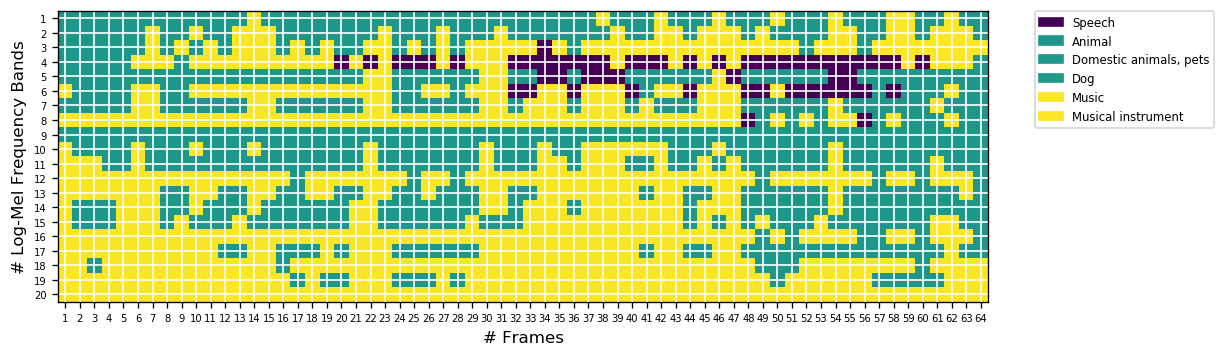

In [20]:
# replication padding
type = 'replication'
model_with_classifier.apply(apply_padding)
label_matrix = predict_4_translation_inv()
plot_trans_inv_preds()
for hook in hooks:
    hook.remove()
hooks = []

Using replication padding for the frequency access helped to retrain more accurate prediction label, `dog` for some of the locations (instead of the more generic animal class).